# Maching Learning with PySpark
Apache Spark's integrated machine learning library is MLlib. The API can be used with Java, Scala, Python, and R.
In this tutorial we will use MLlib and the SQL module with PySpark to do data exploration and build a simple regression model to predict the income of individuals.
The data is available at http://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

## Data Ingestion

In [1]:
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession

# create a SparkContext to connect to a Spark cluster
conf = SparkConf().setMaster('local').setAppName('myApp')
sc = SparkContext(conf=conf)

# create a SparkSession that is the entry point to programming Spark with the Dataset and DataFrame API.
spark = SparkSession(sc)

In [2]:
# read header file
header = sc.textFile('cal_housing.domain').collect() # read header file
header

['longitude: continuous.',
 'latitude: continuous.',
 'housingMedianAge: continuous. ',
 'totalRooms: continuous. ',
 'totalBedrooms: continuous. ',
 'population: continuous. ',
 'households: continuous. ',
 'medianIncome: continuous. ',
 'medianHouseValue: continuous. ']

In [3]:
cal_housing = spark.read.csv("cal_housing.data", 
                             header="false", 
                             sep=",", 
                             inferSchema="true").toDF(*map(lambda x: x.split(':', 1)[0],header))

# show the top 10 rows
cal_housing.show(10)

+---------+--------+----------------+----------+-------------+----------+----------+------------+----------------+
|longitude|latitude|housingMedianAge|totalRooms|totalBedrooms|population|households|medianIncome|medianHouseValue|
+---------+--------+----------------+----------+-------------+----------+----------+------------+----------------+
|  -122.23|   37.88|            41.0|     880.0|        129.0|     322.0|     126.0|      8.3252|        452600.0|
|  -122.22|   37.86|            21.0|    7099.0|       1106.0|    2401.0|    1138.0|      8.3014|        358500.0|
|  -122.24|   37.85|            52.0|    1467.0|        190.0|     496.0|     177.0|      7.2574|        352100.0|
|  -122.25|   37.85|            52.0|    1274.0|        235.0|     558.0|     219.0|      5.6431|        341300.0|
|  -122.25|   37.85|            52.0|    1627.0|        280.0|     565.0|     259.0|      3.8462|        342200.0|
|  -122.25|   37.85|            52.0|     919.0|        213.0|     413.0|     19

## Data Exploration
### Define Summary statistics

In [4]:
cal_housing.select("medianHouseValue").describe().show()

+-------+------------------+
|summary|  medianHouseValue|
+-------+------------------+
|  count|             20640|
|   mean|206855.81690891474|
| stddev|115395.61587441359|
|    min|           14999.0|
|    max|          500001.0|
+-------+------------------+



### Find covariance between attributes

In [5]:
cal_housing.stat.cov("totalRooms", "medianHouseValue")

33772890.18720292

### Find correlation between attributes

In [6]:
cal_housing.stat.corr("medianHouseValue", "medianHouseValue")

1.0

In [7]:
cal_housing.stat.corr("totalRooms","medianHouseValue")

0.13415311380656275

## Data Preprocessing & Feature Engineering
Spark provides different functions to preprocess data. We can handle missing values, normalize the data, bucketize the attribute values etc. Some of these functions are:
- Word2Vec
- Tokenizer
- Binarizer
- PCA
- OneHotEncoder
- Normalizer
- StandardScaler
- StringIndexer
- IndexToString
- StopWordsRemover
- Bucketizer

The example data set does not have missing values.

In our current dataset, we don't have missing values. We have many columns which have huge different between maxmimum and minimum values. We can standardize them. Let's look an example of deadling with missing values.


### Missing Values

In [8]:
names = ["Alice", "Bob", "Mike", "Steve", "Steve"]
items = ["milk", "bread", None, "apples", "apples"]

df = spark.createDataFrame(list(zip(names, items))).toDF("name", "item")
df.show()


+-----+------+
| name|  item|
+-----+------+
|Alice|  milk|
|  Bob| bread|
| Mike|  null|
|Steve|apples|
|Steve|apples|
+-----+------+



### Drop NA rows

In [9]:
df.dropna().show()

+-----+------+
| name|  item|
+-----+------+
|Alice|  milk|
|  Bob| bread|
|Steve|apples|
|Steve|apples|
+-----+------+



### Fill NA values

In [10]:
df.na.fill({'item':'banana'}).show()

+-----+------+
| name|  item|
+-----+------+
|Alice|  milk|
|  Bob| bread|
| Mike|banana|
|Steve|apples|
|Steve|apples|
+-----+------+



### Drop duplicates

In [11]:
df.dropDuplicates().show()

+-----+------+
| name|  item|
+-----+------+
|Steve|apples|
|Alice|  milk|
| Mike|  null|
|  Bob| bread|
+-----+------+



### Frequent Items

In [12]:
support = 0.5
df.freqItems(["item"], support).show()

+--------------+
|item_freqItems|
+--------------+
|      [apples]|
+--------------+



### Back to the Housing Data Example

In [13]:
cal_housing.show(5)

+---------+--------+----------------+----------+-------------+----------+----------+------------+----------------+
|longitude|latitude|housingMedianAge|totalRooms|totalBedrooms|population|households|medianIncome|medianHouseValue|
+---------+--------+----------------+----------+-------------+----------+----------+------------+----------------+
|  -122.23|   37.88|            41.0|     880.0|        129.0|     322.0|     126.0|      8.3252|        452600.0|
|  -122.22|   37.86|            21.0|    7099.0|       1106.0|    2401.0|    1138.0|      8.3014|        358500.0|
|  -122.24|   37.85|            52.0|    1467.0|        190.0|     496.0|     177.0|      7.2574|        352100.0|
|  -122.25|   37.85|            52.0|    1274.0|        235.0|     558.0|     219.0|      5.6431|        341300.0|
|  -122.25|   37.85|            52.0|    1627.0|        280.0|     565.0|     259.0|      3.8462|        342200.0|
+---------+--------+----------------+----------+-------------+----------+-------

### Transform Data

In [14]:
from pyspark.sql.functions import *

cal_housing = cal_housing.withColumn("medianHouseValue", col("medianHouseValue")/100000)
cal_housing.show(5)

+---------+--------+----------------+----------+-------------+----------+----------+------------+----------------+
|longitude|latitude|housingMedianAge|totalRooms|totalBedrooms|population|households|medianIncome|medianHouseValue|
+---------+--------+----------------+----------+-------------+----------+----------+------------+----------------+
|  -122.23|   37.88|            41.0|     880.0|        129.0|     322.0|     126.0|      8.3252|           4.526|
|  -122.22|   37.86|            21.0|    7099.0|       1106.0|    2401.0|    1138.0|      8.3014|           3.585|
|  -122.24|   37.85|            52.0|    1467.0|        190.0|     496.0|     177.0|      7.2574|           3.521|
|  -122.25|   37.85|            52.0|    1274.0|        235.0|     558.0|     219.0|      5.6431|           3.413|
|  -122.25|   37.85|            52.0|    1627.0|        280.0|     565.0|     259.0|      3.8462|           3.422|
+---------+--------+----------------+----------+-------------+----------+-------

### Adding new Columns

* roomsPerHousehold: number of rooms per households
* populationPerHousehold: population per households
* bedroomsPerRoom: number of bedrooms out of total number of rooms


In [15]:
cal_housing = cal_housing.withColumn("roomsPerHousehold", col("totalRooms")/col("households"))\
   .withColumn("populationPerHousehold", col("population")/col("households"))\
   .withColumn("bedroomsPerRoom", col("totalBedRooms")/col("totalRooms"))

cal_housing.select("totalRooms", "totalBedrooms", "households", "roomsPerHousehold", 
                   "populationPerHousehold", "bedroomsPerRoom").show(5)

+----------+-------------+----------+------------------+----------------------+-------------------+
|totalRooms|totalBedrooms|households| roomsPerHousehold|populationPerHousehold|    bedroomsPerRoom|
+----------+-------------+----------+------------------+----------------------+-------------------+
|     880.0|        129.0|     126.0| 6.984126984126984|    2.5555555555555554|0.14659090909090908|
|    7099.0|       1106.0|    1138.0| 6.238137082601054|     2.109841827768014|0.15579659106916466|
|    1467.0|        190.0|     177.0| 8.288135593220339|    2.8022598870056497|0.12951601908657123|
|    1274.0|        235.0|     219.0|5.8173515981735155|     2.547945205479452|0.18445839874411302|
|    1627.0|        280.0|     259.0| 6.281853281853282|    2.1814671814671813| 0.1720958819913952|
+----------+-------------+----------+------------------+----------------------+-------------------+
only showing top 5 rows



### Vectorize multiple columns
The *VectorAssembler* transforms multiple columns into a vector column.

In [16]:
from pyspark.ml.feature import VectorAssembler

vectorAssembler = VectorAssembler(inputCols=['totalBedrooms', 'population', 'households', 'medianIncome', 
                                             'roomsPerHousehold', 'populationPerHousehold', 'bedroomsPerRoom'], 
                                  outputCol = 'features')

cal_housing_vec = vectorAssembler.transform(cal_housing).select("medianHouseValue", "features")

cal_housing_vec.show(10)

+----------------+--------------------+
|medianHouseValue|            features|
+----------------+--------------------+
|           4.526|[129.0,322.0,126....|
|           3.585|[1106.0,2401.0,11...|
|           3.521|[190.0,496.0,177....|
|           3.413|[235.0,558.0,219....|
|           3.422|[280.0,565.0,259....|
|           2.697|[213.0,413.0,193....|
|           2.992|[489.0,1094.0,514...|
|           2.414|[687.0,1157.0,647...|
|           2.267|[665.0,1206.0,595...|
|           2.611|[707.0,1551.0,714...|
+----------------+--------------------+
only showing top 10 rows



### Standardization of Features

In [17]:
from pyspark.ml.feature import StandardScaler

scaler = StandardScaler(inputCol="features", 
                        outputCol="scaledFeatures", 
                        withStd=True, 
                        withMean=False)
# Compute summary statistics by fitting the StandardScaler
scalerModel = scaler.fit(cal_housing_vec)
# Normalize each feature to have unit standard deviation.
scaledData = scalerModel.transform(cal_housing_vec)

scaledData.show(10)

+----------------+--------------------+--------------------+
|medianHouseValue|            features|      scaledFeatures|
+----------------+--------------------+--------------------+
|           4.526|[129.0,322.0,126....|[0.30623297630686...|
|           3.585|[1106.0,2401.0,11...|[2.62553233949916...|
|           3.521|[190.0,496.0,177....|[0.45104081781631...|
|           3.413|[235.0,558.0,219....|[0.55786627466754...|
|           3.422|[280.0,565.0,259....|[0.66469173151877...|
|           2.697|[213.0,413.0,193....|[0.50564049576249...|
|           2.992|[489.0,1094.0,514...|[1.16083663111672...|
|           2.414|[687.0,1157.0,647...|[1.63086864126214...|
|           2.267|[665.0,1206.0,595...|[1.57864286235709...|
|           2.611|[707.0,1551.0,714...|[1.67834662208491...|
+----------------+--------------------+--------------------+
only showing top 10 rows



### Splitting Data intro Training and Test Set

In [18]:
splits = scaledData.randomSplit([0.7, 0.3],seed=13)
train_df = splits[0]
test_df = splits[1]
print("Traing set rows: {}\nTesting set rows: {}".format(train_df.count(), test_df.count()))

Traing set rows: 14354
Testing set rows: 6286


### Train Regression Model

In [19]:
from pyspark.ml.regression import LinearRegression

# configure model
lr = LinearRegression(featuresCol = 'scaledFeatures', 
                      labelCol='medianHouseValue', 
                      maxIter=10, 
                      regParam=0.3, elasticNetParam=0.8)
# Train model
model = lr.fit(train_df)

trainSummary = model.summary
print("RMSE: %f" % trainSummary.rootMeanSquaredError)
print("r2: %f" % trainSummary.r2)

RMSE: 0.880718
r2: 0.417920


### Test Regression Model

In [20]:
predictions = model.transform(test_df)

from pyspark.ml.evaluation import RegressionEvaluator
evaluator = RegressionEvaluator(predictionCol="prediction", 
                                labelCol="medianHouseValue", 
                                metricName="r2")
print("R Squared (R2) on test data = %g" % evaluator.evaluate(predictions))

R Squared (R2) on test data = 0.418386


## ML Pipeline
ML Pipelines provide a uniform set of high-level APIs built on top of DataFrames that help users create and tune practical machine learning pipelines ( https://spark.apache.org/docs/latest/ml-pipeline.html ).
The pipeline components are:
- **Transformer**:  is an abstraction that includes feature transformers and learned models. Implements the *transform()* method and transforms a DataFrame into another DataFrame.
- **Estimator**: abstracts the concept of a learning algorithm or any algorithm that fits or trains on data. Implements the *fit()* method. Uses a DataFrame and produces a Model.
- **Pipeline**:  is a sequence of estimators and transformers that are run in a specific order.

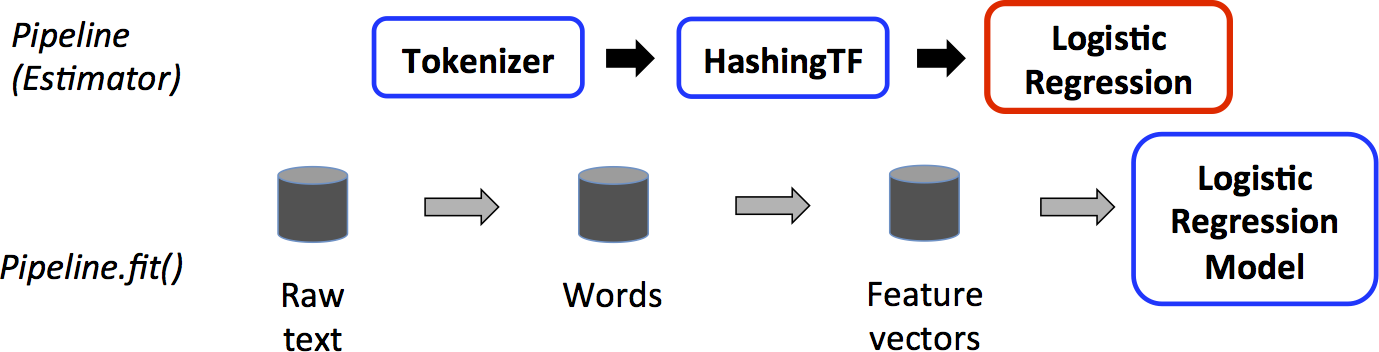 <br>
                    <center> <b>Image Source</b>: https://spark.apache.org/docs/2.1.0/ml-pipeline.html</center>



The following ML pipeline will use the wine data set from http://mlr.cs.umass.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv to predict the wine quality.

### Read Data

In [21]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("spark_ml_app") .config(conf=SparkConf()).getOrCreate()

wines = spark.read.csv("winequality-red.csv", 
                       header="true", 
                       sep=";", 
                       inferSchema="true")

wines.show(5)

+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+
|fixed_acidity|volatile_acidity|citric_acid|residual_sugar|chlorides|free_sulfur_dioxide|total_sulfur_dioxide|density|  pH|sulphates|alcohol|quality|
+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+
|          7.4|             0.7|        0.0|           1.9|    0.076|               11.0|                34.0| 0.9978|3.51|     0.56|    9.4|      5|
|          7.8|            0.88|        0.0|           2.6|    0.098|               25.0|                67.0| 0.9968| 3.2|     0.68|    9.8|      5|
|          7.8|            0.76|       0.04|           2.3|    0.092|               15.0|                54.0|  0.997|3.26|     0.65|    9.8|      5|
|         11.2|            0.28|       0.56|           1.9|    0.075|               17.0|           

### Preprocessing and Train Model

In [22]:
from pyspark.ml.feature import Bucketizer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline

# split dataset into train and test
splits = wines.randomSplit([0.7, 0.3], seed=13)
train_df = splits[0]
test_df = splits[1]

# create vector from data columns
vectorAssembler = VectorAssembler(inputCols=wines.columns[:-1], 
                                  outputCol='features')

scaler = StandardScaler(inputCol="features", 
                        outputCol="scaledFeatures", 
                        withStd=False,
                        withMean=True)

rf = RandomForestClassifier(labelCol="quality", featuresCol="scaledFeatures", numTrees = 10)

# Build the pipeline 
pipeline = Pipeline(stages=[vectorAssembler, scaler, rf])

# Train the model
model = pipeline.fit(train_df)

# Make predictions
predictions = model.transform(test_df)
predictions.select("quality", "prediction").show(10)

+-------+----------+
|quality|prediction|
+-------+----------+
|      6|       7.0|
|      6|       6.0|
|      7|       7.0|
|      6|       6.0|
|      7|       7.0|
|      6|       6.0|
|      6|       6.0|
|      6|       5.0|
|      5|       5.0|
|      6|       6.0|
+-------+----------+
only showing top 10 rows



### Evaluate Model

In [23]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(labelCol="quality", 
                                              predictionCol="prediction", 
                                              metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Error = %g" % (1.0 - accuracy))

Test Error = 0.381339


### Cross Validation in Spark

In [24]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

paramGrid = ParamGridBuilder().addGrid(rf.numTrees, [3, 20]).build()

cv = CrossValidator(estimator=pipeline, 
                    evaluator=evaluator, 
                    estimatorParamMaps=paramGrid, 
                    numFolds=3)

cvModel = cv.fit(train_df)
predictions = cvModel.transform(test_df)

accuracy = evaluator.evaluate(predictions)

print("Test Error = %g" % (1.0 - accuracy))

best_pipeline = cvModel.bestModel
best_pipeline.stages

Test Error = 0.387424


[VectorAssembler_0d950ae46c31,
 StandardScaler_0ee53d11b4fa,
 RandomForestClassificationModel (uid=RandomForestClassifier_68aa17d4f6e2) with 20 trees]

## Saving and Loading Model
### Save Model

In [25]:
model.write().overwrite().save("wine-model")

### Load Model

In [26]:
from pyspark.ml import PipelineModel
# load model from disk
wine_model = PipelineModel.read().load("wine-model")

# use model to predict
predictions = wine_model.transform(test_df)

predictions.select("quality", "prediction").show(10)

+-------+----------+
|quality|prediction|
+-------+----------+
|      6|       7.0|
|      6|       6.0|
|      7|       7.0|
|      6|       6.0|
|      7|       7.0|
|      6|       6.0|
|      6|       6.0|
|      6|       5.0|
|      5|       5.0|
|      6|       6.0|
+-------+----------+
only showing top 10 rows



### Exercise 01
Please download the [titanic data set](https://www.kaggle.com/c/titanic) and predict whether a person is survived or not.Let's look how spark facilitate to save and load model.

##### Load DataSet

In [27]:
#Your code goes here

##### Preporcess data

- **Handling missing values**: Replace missing values in the age column to the mean of that column.
- **Handling categorical columns**: *sex* and *embarked* are categorical variables, so handle them using StringIndexer and OneHotEncoding. You can use some other transformer from Spark's provided transformers as well.
- **Define features**: Define your feature attributes using the VectorAssembler.

In [28]:
#Your code goes here

##### Split into training (75%) and testing (25%) data.

In [29]:
#Your code goes here

##### Define pipeline using RandomForest and train the model

In [30]:
#Your code goes here

##### Test and report accuracy of your model

In [31]:
#Your code goes here

### Exercise 02

Build whole pipeline to perform Kmean clustering on the [Iris dataset](https://archive.ics.uci.edu/ml/datasets/iris).

In [32]:
#Your code goes here

## References
1. [Statistical Data Exploration using Spark](http://blog.madhukaraphatak.com/statistical-data-exploration-spark-part-1/)
2. [ML-programming-guide](https://spark.apache.org/docs/latest/ml-guide.html)
3. https://www.simplilearn.com/spark-streaming-tutorial-video
4. https://spark.apache.org/docs/latest/ml-pipeline.html